In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as sco

In [6]:
path_monthly_prices = '/Users/ahmadroukain/Desktop/Cours/S2/Sustainable asset managmenet/Project 1/Data/DS_RI_T_USD_M.xlsx'
path_yearly_prices = '/Users/ahmadroukain/Desktop/Cours/S2/Sustainable asset managmenet/Project 1/Data/DS_RI_T_USD_Y_CAI.xlsx'
path_companies = '/Users/ahmadroukain/Desktop/Cours/S2/Sustainable asset managmenet/Project 1/Data/Static.xlsx'
path_monthly_value = '/Users/ahmadroukain/Desktop/Cours/S2/Sustainable asset managmenet/Project 1/Data/DS_MV_USD_M.xlsx'
path_rf = '/Users/ahmadroukain/Desktop/Cours/S2/Sustainable asset managmenet/Project 1/Risk_Free_Rate.xlsx'
path_c_1 = '/Users/ahmadroukain/Desktop/Cours/S2/Sustainable asset managmenet/Project 1/Data/TC_Scope1.xlsx'
path_c_2 = '/Users/ahmadroukain/Desktop/Cours/S2/Sustainable asset managmenet/Project 1/Data/TC_Scope2.xlsx'
path_c_3 = '/Users/ahmadroukain/Desktop/Cours/S2/Sustainable asset managmenet/Project 1/Data/TC_Scope3.xlsx'
path_ci_1 = '/Users/ahmadroukain/Desktop/Cours/S2/Sustainable asset managmenet/Project 1/Data/TC_Scope1Intensity.xlsx'
path_ci_2 = '/Users/ahmadroukain/Desktop/Cours/S2/Sustainable asset managmenet/Project 1/Data/TC_Scope2Intensity.xlsx'
path_ci_3 = '/Users/ahmadroukain/Desktop/Cours/S2/Sustainable asset managmenet/Project 1/Data/TC_Scope3Intensity.xlsx'
path_df_annual_v = '/Users/ahmadroukain/Desktop/Cours/S2/Sustainable asset managmenet/Project 1/Data/DS_MV_USD_Y_CAI.xlsx'



In [7]:
# Defining function to read and sort the dataframes (highly polluting sectors and removes companies with unusual price movements)
def read_and_sort_df(path):
    companies = pd.read_excel(path_companies)
    sectors = ['Energy', 'Materials', 'Utilities', 'Consumer Staples']
    companies = companies[companies['GICSSectorName'].isin(sectors)]
    isin_list = []
    for i in companies['ISIN']:
        isin_list.append(i)
    df = pd.read_excel(path)
    df = df[df['ISIN'].isin(isin_list)]
    df.drop(columns='ISIN', inplace=True)
    df = df.transpose()
    df.columns = df.iloc[0]
    df = df.iloc[1:]
    df.drop(columns=['INDOFOOD SUKSES MAKMUR', 'ICT.TUNGGAL PRAKARSA', 'ASTRA AGRO LESTARI'], inplace=True)
    return df

def optimize_and_report(df):
    # creates tulpes for rolling window
    sample_start = 0
    pred_size = 12
    sample_stop = sample_start + 72
    pred_start = sample_stop
    pred_stop = pred_start + pred_size
    ls_windows = [(range(sample_start, sample_stop), range(pred_start - 1, pred_stop))]

    while pred_stop < len(df.index):
        sample_start += pred_size
        sample_stop += pred_size
        pred_start += pred_size
        pred_stop = pred_start
        while (pred_stop < len(df.index)) and (len(range(pred_start, pred_stop)) < pred_size):
            pred_stop += 1
        ls_windows.append((range(sample_start, sample_stop), range(pred_start - 1, pred_stop)))

    # creates list and dataframes for the storage of the performance
    portfolio_returns = []
    portfolio_volatility = []
    annual_portfolio_weights = pd.DataFrame()
    monthly_portfolio_weights = pd.DataFrame()

    # optimization and reporting rolling the window
    for window, year in zip(ls_windows, range(18)):
        df_sample = df.iloc[window[0]]
        df_sample = df_sample.pct_change().iloc[1:]
        vcv = df_sample.cov()
        number_securities = vcv.shape[0]
        def port_vol(weights):
            return np.sqrt(np.dot(weights.T, np.dot(vcv * 12, weights)))
        cons = ({'type':'eq', 'fun' : lambda x : np.sum(x) - 1})
        x0 = np.array(number_securities*[1 / number_securities])
        bnds = tuple((0, 1) for x in range(number_securities))
        opt_gmv = sco.minimize(port_vol, x0, method='SLSQP', bounds=bnds, constraints=cons)
        optimal_weights = opt_gmv.x
        annual_portfolio_weights[f"period {year}"] = optimal_weights
        first_iteration = True
        for i in range(12):
            returns = df.iloc[window[1]].pct_change()
            returns = returns.iloc[1:]
            returns_period = returns.iloc[i]
            if first_iteration:
                returns_portfolio = np.dot(returns_period, optimal_weights)
                new_optimal_weights = np.array(annual_portfolio_weights.iloc[:, -1]) * np.array(((1 + returns_period) / (1 + returns_portfolio)))
                monthly_portfolio_weights[f"month{i}year{year}"] = new_optimal_weights
                portfolio_returns.append(returns_portfolio)
                first_iteration = False
            else:
                returns_portfolio = np.dot(monthly_portfolio_weights.iloc[:, -1], returns_period)
                new_optimal_weights = np.array(monthly_portfolio_weights.iloc[:, -1]) * np.array(((1 + returns_period) / (1 + returns_portfolio)))
                monthly_portfolio_weights[f"month{i}year{year}"] = new_optimal_weights
                portfolio_returns.append(returns_portfolio)
    avg_return = sum(portfolio_returns) / (276 - 72)
    for i in portfolio_returns:
        volatility = ((i - avg_return)**2)
        portfolio_volatility.append(volatility)
    monthly_volatility = np.sqrt(sum(portfolio_volatility) / (276 - 72))
    return monthly_portfolio_weights, annual_portfolio_weights, portfolio_returns, portfolio_volatility, avg_return, monthly_volatility

In [8]:
df_p = read_and_sort_df(path_monthly_prices)

# 1.1

In [9]:
optimization_1 = optimize_and_report(df_p)

/var/folders/zq/cl9wyfm13sq150n30b6r3_6m0000gn/T/ipykernel_31783/3305432595.py:45: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_sample = df_sample.pct_change().iloc[1:]
/var/folders/zq/cl9wyfm13sq150n30b6r3_6m0000gn/T/ipykernel_31783/3305432595.py:58: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  returns = df.iloc[window[1]].pct_change()
/var/folders/zq/cl9wyfm13sq150n30b6r3_6m0000gn/T/ipykernel_31783/3305432595.py:58: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call res

In [10]:
mv_monthly_weights = optimization_1[0]
mv_annual_weights = optimization_1[1]
mv_monthly_returns = pd.Series(optimization_1[2])
mv_avg_return = optimization_1[4]
mv_monthly_volatility = optimization_1[5]

In [11]:
df_rf = pd.read_excel(path_rf, index_col=0, header=0)
df_rf = df_rf / 100
df_rf_period = df_rf.iloc[72:]
rf = df_rf_period.mean().iloc[0]
annualized_avg_return = 12 * mv_avg_return
annualized_vol = np.sqrt(12) * mv_monthly_volatility
monthly_sr = (mv_avg_return - rf) / mv_monthly_volatility
annualized_sr = np.sqrt(12) * monthly_sr
min_return = min(mv_monthly_returns)
max_return = max(mv_monthly_returns)
cum_returns_mv = (1 + mv_monthly_returns).cumprod()
peak = cum_returns_mv.cummax()
drawdown = (cum_returns_mv - peak) / peak
max_drawdown = drawdown.min()
print(annualized_avg_return, annualized_vol, annualized_sr, min_return, max_return, max_drawdown)

0.11957734206253227 0.1148583386792172 0.9289537060753905 -0.11203677054319791 0.11090777637462282 -0.23028454900577527


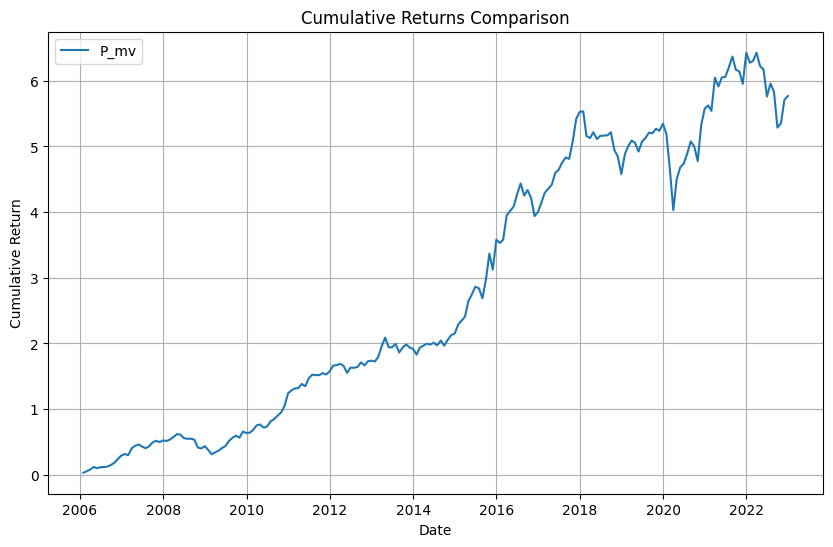

In [12]:
cum_returns_mv.index = df_p.iloc[72:].index
plt.figure(figsize=(10, 6))
plt.plot(cum_returns_mv - 1, label='P_mv')
plt.title('Cumulative Returns Comparison')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()

# 1.2

In [13]:
df_v = read_and_sort_df(path_monthly_value)
df_v = df_v.transpose()
total_monthly_value = df_v.sum(axis=0)
vw_monthly_weights = pd.DataFrame()
for column in df_v.columns:
    vw_monthly_weights[f'{column}'] = df_v[column] / total_monthly_value[column]
vw_monthly_weights = vw_monthly_weights.transpose()
vw_monthly_weights = vw_monthly_weights.iloc[71:]
vw_monthly_weights = vw_monthly_weights.iloc[:-1]

/var/folders/zq/cl9wyfm13sq150n30b6r3_6m0000gn/T/ipykernel_31783/958294724.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vw_monthly_weights[f'{column}'] = df_v[column] / total_monthly_value[column]
/var/folders/zq/cl9wyfm13sq150n30b6r3_6m0000gn/T/ipykernel_31783/958294724.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vw_monthly_weights[f'{column}'] = df_v[column] / total_monthly_value[column]
/var/folders/zq/cl9wyfm13sq150n30b6r3_6m0000gn/T/ipykernel_31783/958294724.py:6: PerformanceWarning: DataFrame is highly fragm

In [14]:
df_sRet = df_p.iloc[71:]
df_sRet = df_sRet.pct_change().iloc[1:]
vw_monthly_returns = pd.DataFrame(vw_monthly_weights.values * df_sRet.values).sum(axis=1)
vw_monthly_returns.index = df_sRet.index
vw_avg_return = np.sum(vw_monthly_returns) / (276 - 72)
annualized_vw_avg_return = vw_avg_return * 12
vw_ptf_vol = []
for i in vw_monthly_returns:
        volatility = ((i - vw_avg_return)**2)
        vw_ptf_vol.append(volatility)
vw_monthly_volatility = np.sqrt(sum(vw_ptf_vol) / (276 - 72))
annualized_vw_volatility = vw_monthly_volatility * np.sqrt(12)
vw_monthly_sharpe_ratio = (vw_avg_return - rf) / vw_monthly_volatility
annualized_vw_sharpe_ratio = vw_monthly_sharpe_ratio * np.sqrt(12)
vw_min_return = min(vw_monthly_returns)
vw_max_return = max(vw_monthly_returns)
cum_returns_vw = (1 + vw_monthly_returns).cumprod()
peak_vw = cum_returns_vw.cummax()
drawdown_vw = (cum_returns_vw - peak_vw) / peak_vw
max_drawdown_vw = drawdown_vw.min()
print(annualized_vw_avg_return, annualized_vw_volatility, annualized_vw_sharpe_ratio, vw_min_return, vw_max_return, max_drawdown_vw)

0.07808665691206798 0.15384740783256565 0.4238446078352068 -0.1844438582739877 0.12903973917770328 -0.46847223552602973


/var/folders/zq/cl9wyfm13sq150n30b6r3_6m0000gn/T/ipykernel_31783/899211114.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_sRet = df_sRet.pct_change().iloc[1:]


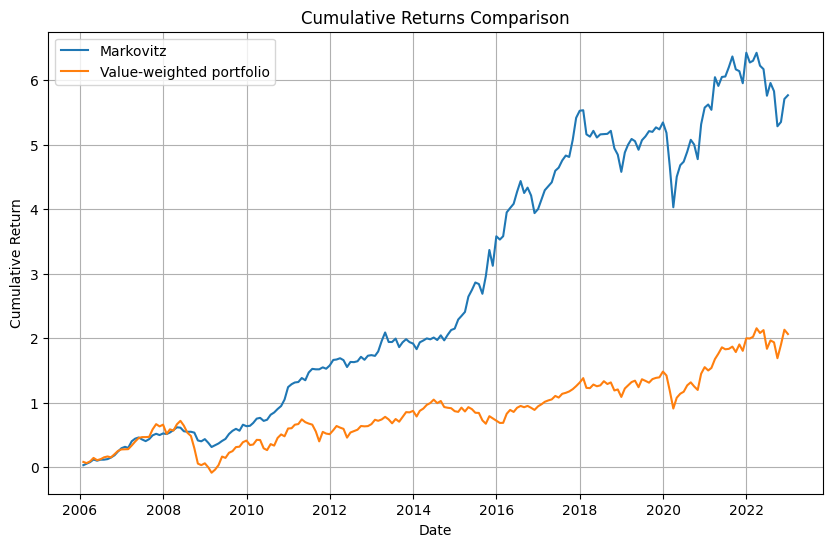

In [15]:
cum_returns_mv.index = vw_monthly_returns.index
cum_returns_vw = (1 + vw_monthly_returns).cumprod()
plt.figure(figsize=(10, 6))
plt.plot(cum_returns_mv - 1, label='Markovitz')
plt.plot(cum_returns_vw - 1, label='Value-weighted portfolio')
plt.title('Cumulative Returns Comparison')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()

# 2.0

In [16]:
df_c_1 = pd.read_excel(path_c_1, index_col=1)
df_ci_1 = pd.read_excel(path_ci_1, index_col=1)
df_c_2 = pd.read_excel(path_c_2, index_col=1)
df_ci_2 = pd.read_excel(path_ci_2, index_col=1)
df_c_3 = pd.read_excel(path_c_3, index_col=1)
df_ci_3 =  pd.read_excel(path_ci_3, index_col=1)

In [17]:
companies = pd.read_excel(path_companies)
sectors = ['Energy', 'Materials', 'Utilities', 'Consumer Staples']
companies = companies[companies['GICSSectorName'].isin(sectors)]
isin_list = []
for i in companies['ISIN']:
    isin_list.append(i)

df_c_1 = df_c_1[df_c_1['ISIN'].isin(isin_list)]
df_c_1.drop(columns='ISIN', inplace=True)
df_c_1 = df_c_1.transpose()
df_c_1.drop(columns=['PT Indofood Sukses Makmur Tbk', 'PT Indocement Tunggal Prakarsa Tbk', 'PT Astra Agro Lestari Tbk'], inplace=True)
df_c_1 = df_c_1.iloc[6:]

df_ci_1 = df_ci_1[df_ci_1['ISIN'].isin(isin_list)]
df_ci_1.drop(columns='ISIN', inplace=True)
df_ci_1 = df_ci_1.transpose()
df_ci_1.drop(columns=['PT Indofood Sukses Makmur Tbk', 'PT Indocement Tunggal Prakarsa Tbk', 'PT Astra Agro Lestari Tbk'], inplace=True)
df_ci_1 = df_ci_1.iloc[6:]

df_c_2 = df_c_2[df_c_2['ISIN'].isin(isin_list)]
df_c_2.drop(columns='ISIN', inplace=True)
df_c_2 = df_c_2.transpose()
df_c_2.drop(columns=['PT Indofood Sukses Makmur Tbk', 'PT Indocement Tunggal Prakarsa Tbk', 'PT Astra Agro Lestari Tbk'], inplace=True)
df_c_2 = df_c_2.iloc[6:]

df_ci_2 = df_ci_2[df_ci_2['ISIN'].isin(isin_list)]
df_ci_2.drop(columns='ISIN', inplace=True)
df_ci_2 = df_ci_2.transpose()
df_ci_2.drop(columns=['PT Indofood Sukses Makmur Tbk', 'PT Indocement Tunggal Prakarsa Tbk', 'PT Astra Agro Lestari Tbk'], inplace=True)
df_ci_2 = df_ci_2.iloc[6:]

df_c_3 = df_c_3[df_c_3['ISIN'].isin(isin_list)]
df_c_3.drop(columns='ISIN', inplace=True)
df_c_3 = df_c_3.transpose()
df_c_3.drop(columns=['PT Indofood Sukses Makmur Tbk', 'PT Indocement Tunggal Prakarsa Tbk', 'PT Astra Agro Lestari Tbk'], inplace=True)
df_c_3 = df_c_3.iloc[6:]

df_ci_3 = df_ci_3[df_ci_3['ISIN'].isin(isin_list)]
df_ci_3.drop(columns='ISIN', inplace=True)
df_ci_3 = df_ci_3.transpose()
df_ci_3.drop(columns=['PT Indofood Sukses Makmur Tbk', 'PT Indocement Tunggal Prakarsa Tbk', 'PT Astra Agro Lestari Tbk'], inplace=True)
df_ci_3 = df_ci_3.iloc[6:]

In [18]:
df_ci = df_ci_1 + df_ci_2 + df_ci_3
df_c = df_c_1 + df_c_2 + df_c_3

In [19]:
mv_annual_weights = mv_annual_weights.transpose()
mv_annual_weights = mv_annual_weights.set_index(df_ci.index)
mv_annual_weights.columns = df_ci.columns

# 2.1

In [20]:
df_ci = df_ci.bfill()
waci_mv = mv_annual_weights * df_ci
waci_mv = waci_mv.sum(axis=1)
print(waci_mv)

2005    2473.588943
2006    2261.138313
2007    1393.777290
2008     881.081826
2009    1982.999263
2010    2199.335635
2011    2091.701677
2012    1925.987028
2013    2018.958186
2014    4069.630468
2015    1871.799903
2016    1713.196325
2017    1049.027594
2018    1489.966698
2019    1982.790850
2020    2175.834556
2021    1203.345079
dtype: float64

In [21]:
df_annual_v = pd.read_excel(path_df_annual_v, index_col=1)
df_annual_v = df_annual_v[df_annual_v['ISIN'].isin(isin_list)]
df_annual_v.drop(columns='ISIN', inplace=True)
df_annual_v = df_annual_v.transpose()
df_annual_v.drop(columns=['INDOFOOD SUKSES MAKMUR', 'ICT.TUNGGAL PRAKARSA', 'ASTRA AGRO LESTARI'], inplace=True)
df_annual_v.columns = df_c.columns
df_annual_v = df_annual_v.iloc[6:-1]

In [22]:
wealth_2005 = pd.Series(1000000)
every_12_values = cum_returns_mv.iloc[11::12]
new_serie = pd.concat([every_12_values, wealth_2005])
new_serie2 = new_serie.shift(1)
new_serie2.iloc[0] = 1
new_serie2 = new_serie2.iloc[:-1]
new_serie2.index = waci_mv.index
V = new_serie2 * 1000000
v = pd.DataFrame()
for i in range(2005, 2022):
    v[f'{i}'] = mv_annual_weights.loc[i].mul(V.loc[i])
v = v.transpose()
o = pd.DataFrame(v.values / df_annual_v.values)
e = df_c.copy()
cf_mv = pd.DataFrame((o.values * e.values)).sum(axis=1)
cf_mv = pd.Series(cf_mv.values / V.values)
cf_mv.index = waci_mv.index
print(cf_mv)

2005     1204.440764
2006      950.596964
2007      899.921394
2008      931.110189
2009     1655.908748
2010     1502.201281
2011     1583.973083
2012     1918.868041
2013     2158.162618
2014     6052.575795
2015     1671.225623
2016     1793.169515
2017     1215.463592
2018     7556.543709
2019    16394.744161
2020     8404.535075
2021     3028.822184
dtype: float64

In [23]:
cf_mv = mv_annual_weights * (df_c / df_annual_v)
cf_mv = cf_mv.sum(axis=1)
print(cf_mv)

2005     1204.440764
2006      950.596964
2007      899.921394
2008      931.110189
2009     1655.908748
2010     1502.201281
2011     1583.973083
2012     1918.868041
2013     2158.162618
2014     6052.575795
2015     1671.225623
2016     1793.169515
2017     1215.463592
2018     7556.543709
2019    16394.744161
2020     8404.535075
2021     3028.822184
dtype: float64

# 2.2

In [27]:
def optimize_and_report_2(df):
    # creates tulpes for rolling window
    sample_start = 0
    pred_size = 12
    sample_stop = sample_start + 72
    pred_start = sample_stop
    pred_stop = pred_start + pred_size
    ls_windows = [(range(sample_start, sample_stop), range(pred_start-1, pred_stop))]

    while pred_stop < len(df.index):
        sample_start += pred_size
        sample_stop += pred_size
        pred_start += pred_size
        pred_stop = pred_start
        while (pred_stop < len(df.index)) and (len(range(pred_start, pred_stop)) < pred_size):
            pred_stop += 1
        ls_windows.append((range(sample_start, sample_stop), range(pred_start - 1, pred_stop)))

    # creates list and dataframes for the storage of the performance
    portfolio_returns = []
    portfolio_volatility = []
    annual_portfolio_weights = pd.DataFrame()
    monthly_portfolio_weights = pd.DataFrame()

    # optimization and reporting rolling the window
    for window, year in zip(ls_windows, range(18)):
        df_sample = df.iloc[window[0]]
        df_sample = df_sample.pct_change().iloc[1:]
        vcv = df_sample.cov()
        number_securities = vcv.shape[0]
        def port_vol(weights):
            return np.sqrt(np.dot(weights.T, np.dot(vcv * 12, weights)))
        def cons2(weights):
            cf_self = weights * (df_c.iloc[year] / df_annual_v.iloc[year])
            cf_self = cf_self.sum()
            z = cf_mv.iloc[year] * 0.5 - cf_self
            return z
        cons = ({'type':'eq', 'fun' : lambda x : np.sum(x) - 1}, {'type' : 'ineq', 'fun' : cons2})
        x0 = np.array(number_securities*[1 / number_securities])
        bnds = tuple((0, 1) for x in range(number_securities))
        opt_gmv = sco.minimize(port_vol, x0, method='SLSQP', bounds=bnds, constraints=cons)
        optimal_weights = opt_gmv.x
        annual_portfolio_weights[f"period {year}"] = optimal_weights
        first_iteration = True
        for i in range(12):
            returns = df.iloc[window[1]].pct_change()
            returns = returns.iloc[1:]
            returns_period = returns.iloc[i]
            if first_iteration:
                returns_portfolio = np.dot(returns_period, optimal_weights)
                new_optimal_weights = np.array(annual_portfolio_weights.iloc[:, -1]) * np.array(((1 + returns_period) / (1 + returns_portfolio)))
                monthly_portfolio_weights[f"month{i}year{year}"] = new_optimal_weights
                portfolio_returns.append(returns_portfolio)
                first_iteration = False
            else:
                returns_portfolio = np.dot(monthly_portfolio_weights.iloc[:, -1], returns_period)
                new_optimal_weights = np.array(monthly_portfolio_weights.iloc[:, -1]) * np.array(((1 + returns_period) / (1 + returns_portfolio)))
                monthly_portfolio_weights[f"month{i}year{year}"] = new_optimal_weights
                portfolio_returns.append(returns_portfolio)
    avg_return = sum(portfolio_returns) / (276 - 72)
    for i in portfolio_returns:
        volatility = ((i - avg_return)**2)
        portfolio_volatility.append(volatility)
    monthly_volatility = np.sqrt(sum(portfolio_volatility) / (276 - 72))
    return monthly_portfolio_weights, annual_portfolio_weights, portfolio_returns, portfolio_volatility, avg_return, monthly_volatility

In [28]:
optimization_2 = optimize_and_report_2(df_p)

/var/folders/zq/cl9wyfm13sq150n30b6r3_6m0000gn/T/ipykernel_31783/307565771.py:28: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_sample = df_sample.pct_change().iloc[1:]
/var/folders/zq/cl9wyfm13sq150n30b6r3_6m0000gn/T/ipykernel_31783/307565771.py:46: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  returns = df.iloc[window[1]].pct_change()
/var/folders/zq/cl9wyfm13sq150n30b6r3_6m0000gn/T/ipykernel_31783/307565771.py:46: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result

In [29]:
mv_c_monthly_weights = optimization_2[0]
mv_c_annual_weights = optimization_2[1]
mv_c_monthly_returns = pd.Series(optimization_2[2])
mv_c_avg_return = optimization_2[4]
mv_c_monthly_volatility = optimization_2[5]

In [30]:
annualized_avg_return_mv_c = 12 * mv_c_avg_return
annualized_vol_mv_c = np.sqrt(12) * mv_c_monthly_volatility
monthly_sr_mv_c = (mv_c_avg_return - rf) / mv_c_monthly_volatility
annualized_sr_mv_c = np.sqrt(12) * monthly_sr_mv_c
min_return_mv_c = min(mv_c_monthly_returns)
max_return_mv_c = max(mv_c_monthly_returns)
cum_returns_mv_c = (1 + mv_c_monthly_returns).cumprod()
peak_mv_c = cum_returns_mv_c.cummax()
drawdown_mv_c = (cum_returns_mv_c - peak_mv_c) / peak_mv_c
max_drawdown_mv_c = drawdown_mv_c.min()
print(annualized_avg_return_mv_c, annualized_vol_mv_c, annualized_sr_mv_c, min_return_mv_c, max_return_mv_c, max_drawdown_mv_c)

0.1207607769275884 0.11693070536401416 0.9226106514874256 -0.11384025692873226 0.11092656023658988 -0.22994739584505872


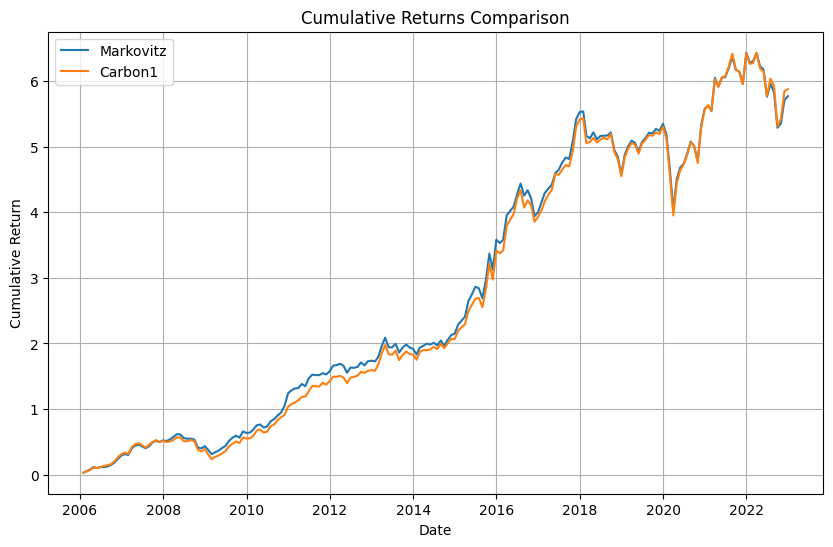

In [31]:
cum_returns_mv_c.index = cum_returns_mv.index
plt.figure(figsize=(10, 6))
plt.plot(cum_returns_mv - 1, label='Markovitz')
plt.plot(cum_returns_mv_c - 1, label='Carbon1')
plt.title('Cumulative Returns Comparison')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()

In [32]:
waci_mv_c = mv_c_annual_weights.transpose().values * df_ci.values
waci_mv_c = waci_mv_c.sum(axis=1)
print(pd.Series(waci_mv_c, index=df_ci.index))

2005    1857.685115
2006    1496.345130
2007     931.054802
2008     545.120717
2009    1527.502494
2010    1829.189461
2011    1938.279614
2012    1805.727251
2013    1627.875678
2014    3623.276951
2015    1053.999925
2016    1126.414322
2017     793.372456
2018    1214.718531
2019    1420.667066
2020    1909.413118
2021     834.964284
dtype: float64

In [33]:
cf_mv2 = mv_c_annual_weights.transpose().values * (df_c.values / df_annual_v.values)
cf_mv2 = pd.DataFrame(cf_mv2)
cf_mv2 = cf_mv2.sum(axis=1)
print(cf_mv2)

0      602.220382
1      475.298482
2      449.960697
3      465.555095
4      827.954374
5      751.100641
6      791.986541
7      959.434021
8     1079.081309
9     3026.287897
10     835.612811
11     896.584758
12     607.731796
13    3778.271855
14    8197.372081
15    4202.267538
16    1514.411092
dtype: float64

In [34]:
vw_annual_weights = vw_monthly_weights.iloc[::12]
cap_y = df_annual_v.sum(axis=1)
df_c_annual = df_c.sum(axis=1)
cf_vw = df_c_annual / cap_y
print(cf_vw)

2005    1368.617483
2006    1140.063082
2007     971.311800
2008    1585.336633
2009    1181.784045
2010    1090.681402
2011    1285.316233
2012    1187.878118
2013    1095.087570
2014    1100.694008
2015    1125.957875
2016    1035.945548
2017     945.412352
2018    1110.401368
2019     924.349154
2020     817.698895
2021     825.675888
dtype: float64

In [35]:
waci_vw = vw_annual_weights.values * df_ci.values
waci_vw = waci_vw.sum(axis=1)
print(pd.Series(waci_vw, index=df_ci.index))


2005     1437.61456
2006    1390.444849
2007    1339.417253
2008    1143.673054
2009    1270.127136
2010    1140.199916
2011     1019.13381
2012    1007.369853
2013     966.988662
2014    1073.346658
2015    1008.151898
2016    1151.408098
2017    1067.148894
2018    1006.801898
2019     957.498539
2020     940.895738
2021      900.43073
dtype: object

# 2.3

In [38]:
def optimize_and_report_3(df):
    # creates tulpes for rolling window
    sample_start = 0
    pred_size = 12
    sample_stop = sample_start + 72
    pred_start = sample_stop
    pred_stop = pred_start + pred_size
    ls_windows = [(range(sample_start, sample_stop), range(pred_start-1, pred_stop))]

    while pred_stop < len(df.index):
        sample_start += pred_size
        sample_stop += pred_size
        pred_start += pred_size
        pred_stop = pred_start
        while (pred_stop < len(df.index)) and (len(range(pred_start, pred_stop)) < pred_size):
            pred_stop += 1
        ls_windows.append((range(sample_start, sample_stop), range(pred_start - 1, pred_stop)))

    # creates list and dataframes for the storage of the performance
    portfolio_returns = []
    portfolio_volatility = []
    annual_portfolio_weights = pd.DataFrame()
    monthly_portfolio_weights = pd.DataFrame()

    # optimization and reporting rolling the window
    for window, year in zip(ls_windows, range(18)):
        df_sample = df.iloc[window[0]]
        df_sample = df_sample.pct_change().iloc[1:]
        vcv = df_sample.cov()
        number_securities = vcv.shape[0]
        def port_vol(weights):
            te = weights - vw_annual_weights.iloc[year]
            return (np.dot(te.T, np.dot(vcv * 12, te))) # np.sqrt(np.dot(weights.T, np.dot(vcv * 12, weights)))
        def cons2(weights):
            cf_self = weights * (df_c.iloc[year] / df_annual_v.iloc[year])
            cf_self = cf_self.sum()
            z = cf_vw.iloc[year] * 0.5 - cf_self
            return z
        cons = ({'type':'eq', 'fun' : lambda x : np.sum(x) - 1}, {'type' : 'ineq', 'fun' : cons2})
        x0 = np.array(number_securities*[1 / number_securities])
        bnds = tuple((0, 1) for x in range(number_securities))
        opt_gmv = sco.minimize(port_vol, x0, bounds=bnds, constraints=cons)
        optimal_weights = opt_gmv.x
        annual_portfolio_weights[f"period {year}"] = optimal_weights
        first_iteration = True
        for i in range(12):
            returns = df.iloc[window[1]].pct_change()
            returns = returns.iloc[1:]
            returns_period = returns.iloc[i]
            if first_iteration:
                returns_portfolio = np.dot(returns_period, optimal_weights)
                new_optimal_weights = np.array(annual_portfolio_weights.iloc[:, -1]) * np.array(((1 + returns_period) / (1 + returns_portfolio)))
                monthly_portfolio_weights[f"month{i}year{year}"] = new_optimal_weights
                portfolio_returns.append(returns_portfolio)
                first_iteration = False
            else:
                returns_portfolio = np.dot(monthly_portfolio_weights.iloc[:, -1], returns_period)
                new_optimal_weights = np.array(monthly_portfolio_weights.iloc[:, -1]) * np.array(((1 + returns_period) / (1 + returns_portfolio)))
                monthly_portfolio_weights[f"month{i}year{year}"] = new_optimal_weights
                portfolio_returns.append(returns_portfolio)
    avg_return = sum(portfolio_returns) / (276 - 72)
    for i in portfolio_returns:
        volatility = ((i - avg_return)**2)
        portfolio_volatility.append(volatility)
    monthly_volatility = np.sqrt(sum(portfolio_volatility) / (276 - 72))
    return monthly_portfolio_weights, annual_portfolio_weights, portfolio_returns, portfolio_volatility, avg_return, monthly_volatility

In [39]:
optimization_3 = optimize_and_report_3(df_p)

/var/folders/zq/cl9wyfm13sq150n30b6r3_6m0000gn/T/ipykernel_31783/290377935.py:28: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_sample = df_sample.pct_change().iloc[1:]
/var/folders/zq/cl9wyfm13sq150n30b6r3_6m0000gn/T/ipykernel_31783/290377935.py:47: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  returns = df.iloc[window[1]].pct_change()
/var/folders/zq/cl9wyfm13sq150n30b6r3_6m0000gn/T/ipykernel_31783/290377935.py:47: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result

In [40]:
vw_c_monthly_weights = optimization_3[0]
vw_c_annual_weights = optimization_3[1]
vw_c_monthly_returns = pd.Series(optimization_3[2])
vw_c_avg_return = optimization_3[4]
vw_c_monthly_volatility = optimization_3[5]

In [41]:
vw_c_annualized_avg_return = 12 * vw_c_avg_return
vw_c_annualized_vol = np.sqrt(12) * vw_c_monthly_volatility
vw_c_monthly_sr = (vw_c_avg_return - rf) / vw_c_monthly_volatility
vw_c_annualized_sr = np.sqrt(12) * vw_c_monthly_sr
vw_c_min_return = min(vw_c_monthly_returns)
vw_c_max_return = max(vw_c_monthly_returns)
cum_returns_vw_c = (1 + vw_c_monthly_returns).cumprod()
peak_vw_c = cum_returns_vw_c.cummax()
drawdown_vw_c = (cum_returns_vw_c - peak_vw_c) / peak_vw_c
vw_c_max_drawdown = drawdown_vw_c.min()
print(vw_c_annualized_avg_return, vw_c_annualized_vol, vw_c_annualized_sr, vw_c_min_return, vw_c_max_return, vw_c_max_drawdown)

0.09052286182152311 0.15505359266920632 0.5007533060801633 -0.20374902922634053 0.12162820006118727 -0.471388508701655


In [42]:
waci_vw_c = vw_c_annual_weights.transpose().values * df_ci.bfill()
waci_vw_c = waci_vw_c.sum(axis=1)
print(waci_vw_c)

2005    826.977464
2006    755.188295
2007    829.600719
2008    661.210880
2009    881.808218
2010    749.122829
2011    665.764614
2012    658.889340
2013    622.085669
2014    742.932866
2015    683.095620
2016    806.376196
2017    803.777945
2018    784.373853
2019    753.027780
2020    713.688851
2021    683.149580
dtype: float64


In [43]:
cf_vw2 = vw_c_annual_weights.transpose().values * (df_c.values / df_annual_v.values)
cf_vw2 = pd.DataFrame(cf_vw2)
cf_vw2 = cf_vw2.sum(axis=1)
print(cf_vw2)

0     684.308742
1     570.031541
2     485.655900
3     792.668317
4     590.892023
5     545.340701
6     642.658116
7     593.939059
8     547.543785
9     550.347004
10    562.978937
11    517.972774
12    472.706176
13    555.200684
14    462.174577
15    408.849447
16    412.837944
dtype: float64


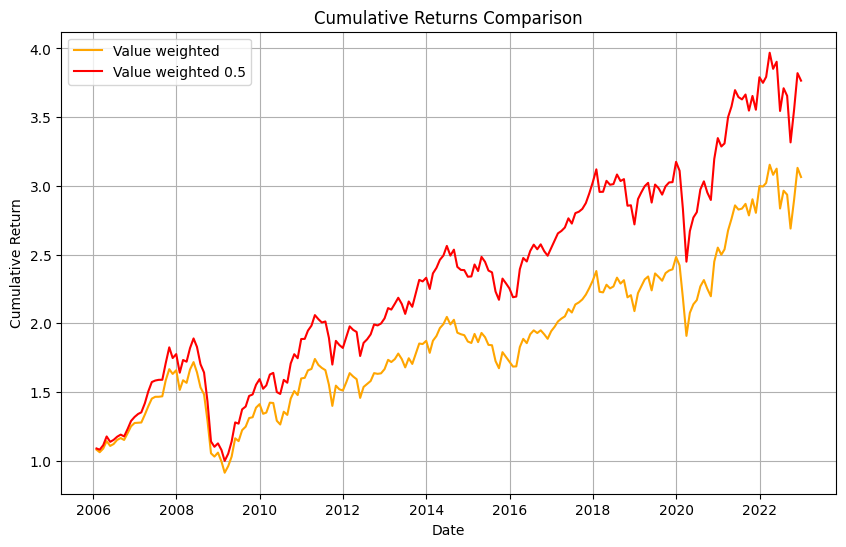

In [44]:
cum_returns_vw_c = (1 + vw_c_monthly_returns).cumprod()
cum_returns_vw_c.index = vw_monthly_returns.index
plt.figure(figsize=(10, 6))
plt.plot(cum_returns_vw, label='Value weighted', color='Orange')
plt.plot(cum_returns_vw_c, label='Value weighted 0.5', color='Red')
plt.title('Cumulative Returns Comparison')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.savefig("figure 2.2.jpg", dpi=300, bbox_inches="tight")
plt.show()

# 3.1

In [45]:
def optimize_and_report_4(df, vw_annual_weights=vw_annual_weights, df_c=df_c, df_annual_v=df_annual_v, cf_vw2=cf_vw2):
    # creates tulpes for rolling window
    sample_start = 0
    pred_size = 12
    sample_stop = sample_start + 72
    pred_start = sample_stop
    pred_stop = pred_start + pred_size
    ls_windows = [(range(sample_start, sample_stop), range(pred_start-1, pred_stop))]

    while pred_stop < len(df.index):
        sample_start += pred_size
        sample_stop += pred_size
        pred_start += pred_size
        pred_stop = pred_start
        while (pred_stop < len(df.index)) and (len(range(pred_start, pred_stop)) < pred_size):
            pred_stop += 1
        ls_windows.append((range(sample_start, sample_stop), range(pred_start - 1, pred_stop)))

    # creates list and dataframes for the storage of the performance
    portfolio_returns = []
    portfolio_volatility = []
    annual_portfolio_weights = pd.DataFrame()
    monthly_portfolio_weights = pd.DataFrame()

    # optimization and reporting rolling the window
    for window, year in zip(ls_windows, range(18)):
        df_sample = df.iloc[window[0]]
        df_sample = df_sample.pct_change().iloc[1:]
        vcv = df_sample.cov()
        number_securities = vcv.shape[0]
        def port_vol(weights):
            te = weights - vw_annual_weights.iloc[year]
            return (np.dot(te.T, np.dot(vcv * 12, te)))
        def cons2(weights):
            cf_self = weights * (df_c.iloc[year] / df_annual_v.iloc[year])
            cf_self = cf_self.sum()
            z = cf_vw.iloc[0] * (0.9**(year + 1)) - cf_self
            return z
        cons = ({'type':'eq', 'fun' : lambda x : np.sum(x) - 1}, {'type' : 'ineq', 'fun' : cons2})
        x0 = np.array(number_securities*[1 / number_securities])
        bnds = tuple((0, 1) for x in range(number_securities))
        opt_gmv = sco.minimize(port_vol, x0, method='SLSQP', bounds=bnds, constraints=cons)
        optimal_weights = opt_gmv.x
        annual_portfolio_weights[f"period {year}"] = optimal_weights
        first_iteration = True
        for i in range(12):
            returns = df.iloc[window[1]].pct_change()
            returns = returns.iloc[1:]
            returns_period = returns.iloc[i]
            if first_iteration:
                returns_portfolio = np.dot(returns_period, optimal_weights)
                new_optimal_weights = np.array(annual_portfolio_weights.iloc[:, -1]) * np.array(((1 + returns_period) / (1 + returns_portfolio)))
                monthly_portfolio_weights[f"month{i}year{year}"] = new_optimal_weights
                portfolio_returns.append(returns_portfolio)
                first_iteration = False
            else:
                returns_portfolio = np.dot(monthly_portfolio_weights.iloc[:, -1], returns_period)
                new_optimal_weights = np.array(monthly_portfolio_weights.iloc[:, -1]) * np.array(((1 + returns_period) / (1 + returns_portfolio)))
                monthly_portfolio_weights[f"month{i}year{year}"] = new_optimal_weights
                portfolio_returns.append(returns_portfolio)
    avg_return = sum(portfolio_returns) / (276 - 72)
    for i in portfolio_returns:
        volatility = ((i - avg_return)**2)
        portfolio_volatility.append(volatility)
    monthly_volatility = np.sqrt(sum(portfolio_volatility) / ( 276 - 72))
    return monthly_portfolio_weights, annual_portfolio_weights, portfolio_returns, portfolio_volatility, avg_return, monthly_volatility

In [46]:
optimization_4 = optimize_and_report_4(df_p)

/var/folders/zq/cl9wyfm13sq150n30b6r3_6m0000gn/T/ipykernel_31783/868914068.py:28: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_sample = df_sample.pct_change().iloc[1:]
/var/folders/zq/cl9wyfm13sq150n30b6r3_6m0000gn/T/ipykernel_31783/868914068.py:47: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  returns = df.iloc[window[1]].pct_change()
/var/folders/zq/cl9wyfm13sq150n30b6r3_6m0000gn/T/ipykernel_31783/868914068.py:47: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result

In [47]:
vw2_c_monthly_weights = optimization_4[0]
vw2_c_annual_weights = optimization_4[1]
vw2_c_monthly_returns = pd.Series(optimization_4[2])
vw2_c_avg_return = optimization_4[4]
vw2_c_monthly_volatility = optimization_4[5]

In [48]:
vw2_c_annualized_avg_return = 12 * vw2_c_avg_return
vw2_c_annualized_vol = np.sqrt(12) * vw2_c_monthly_volatility
vw2_c_monthly_sr = (vw2_c_avg_return - rf) / vw2_c_monthly_volatility
vw2_c_annualized_sr = np.sqrt(12) * vw2_c_monthly_sr
vw2_c_min_return = min(vw2_c_monthly_returns)
vw2_c_max_return = max(vw2_c_monthly_returns)
cum_returns_vw2_c = (1 + vw2_c_monthly_returns).cumprod()
peak_vw2_c = cum_returns_vw2_c.cummax()
drawdown_vw2_c = (cum_returns_vw2_c - peak_vw2_c) / peak_vw2_c
vw2_c_max_drawdown = drawdown_vw2_c.min()
print(vw2_c_annualized_avg_return, vw2_c_annualized_vol, vw2_c_annualized_sr, vw2_c_min_return, vw2_c_max_return, vw2_c_max_drawdown)

0.08965096915096249 0.15498677035292063 0.49534361096327406 -0.20116561955625312 0.12371368012159172 -0.46633096871097085


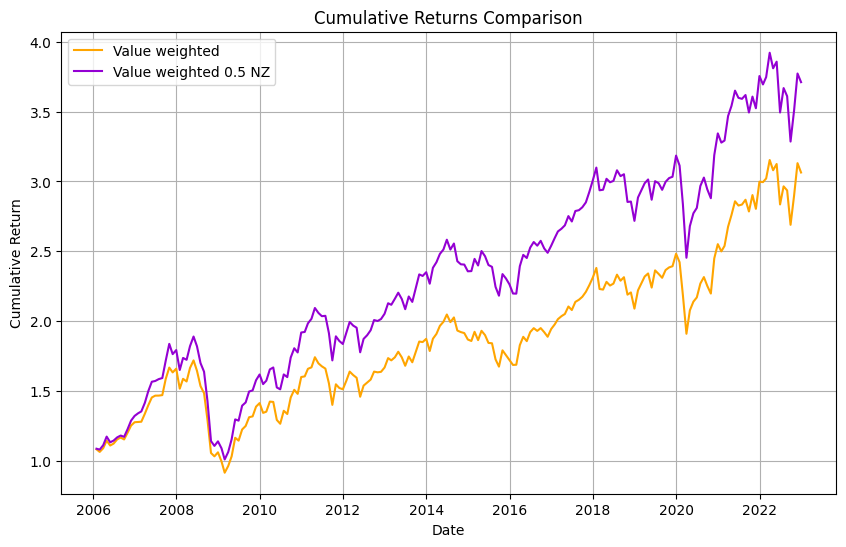

In [49]:
cum_returns_vw2_c = (1 + vw2_c_monthly_returns).cumprod()
cum_returns_vw2_c.index = vw_monthly_returns.index
plt.figure(figsize=(10, 6))
plt.plot(cum_returns_vw, label='Value weighted', color='Orange')
plt.plot(cum_returns_vw2_c, label='Value weighted 0.5 NZ', color='darkviolet')
plt.title('Cumulative Returns Comparison')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.savefig("figure 2.3.jpg", dpi=300, bbox_inches="tight")
plt.show()

In [50]:
cf_vw3 = vw2_c_annual_weights.transpose().values * (df_c.values / df_annual_v.values)
cf_vw3 = pd.DataFrame(cf_vw3)
cf_vw3 = cf_vw3.sum(axis=1)
print(cf_vw3)

0     1230.806825
1     1092.022114
2      968.157896
3      897.949931
4      808.154938
5      727.339444
6      654.605500
7      589.144950
8      530.230455
9      477.207409
10     429.486668
11     386.538001
12     347.884201
13     313.095781
14     281.786203
15     253.607583
16     228.246824
dtype: float64


In [51]:
waci_vw2_c = vw2_c_annual_weights.transpose().values * df_ci.bfill()
waci_vw2_c = waci_vw2_c.sum(axis=1)
print(waci_vw2_c)


2005    1279.165233
2006    1309.002729
2007    1359.710913
2008     724.820525
2009    1065.466188
2010     905.692500
2011     674.906538
2012     653.993424
2013     607.452200
2014     659.317552
2015     560.459523
2016     688.234231
2017     662.541635
2018     532.212069
2019     537.485864
2020     532.382451
2021     485.621921
dtype: float64


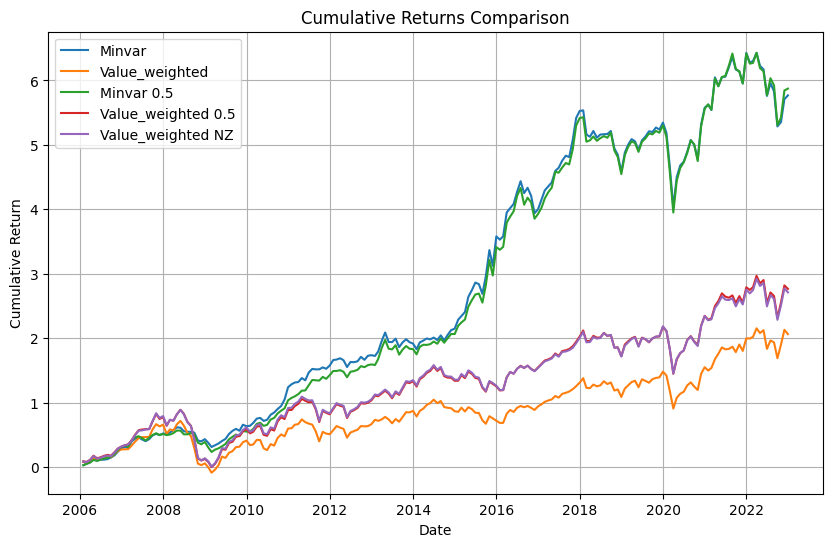

In [52]:
plt.figure(figsize=(10, 6))
plt.plot(cum_returns_mv - 1, label='Minvar')
plt.plot(cum_returns_vw - 1, label='Value_weighted')
plt.plot(cum_returns_mv_c - 1, label='Minvar 0.5')
plt.plot(cum_returns_vw_c - 1, label='Value_weighted 0.5')
plt.plot(cum_returns_vw2_c - 1, label='Value_weighted NZ')
plt.title('Cumulative Returns Comparison')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()